In [ ]:
import os
import json
import glob
import shutil
import random
import jsonlines
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
import matplotlib.cm as cm
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import Counter, OrderedDict
#from mlxtend.evaluate import mcnemar_table,  mcnemar
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Figures and tables for paper

## Exactitude globale 

In [2]:
models_size_shortname = [
    ('Llama-2-7b-chat-hf', 7, 'Llama-2'),
    ('Llama-2-70b-chat-hf', 70, 'Llama-2'),
    ("meditron-7b",7,"Meditron"),
    ("meditron-70b",70,"Meditron"),
    ("Llama3-OpenBioLLM-8B", 8,"Llama3-OpenBioLLM"),
    ("Llama3-OpenBioLLM-70B", 70,"Llama3-OpenBioLLM"),
    ("Meta-Llama-3-70B-Instruct",70,"Llama-3-Instruct"),
    ("Meta-Llama-3-8B-Instruct",8,"Llama-3-Instruct"),
    ("Phi-3-medium-4k-instruct",14,"Phi-3"),
    ("Mixtral-8x22B-Instruct-v0.1",176,"Mixtral-8x22"),
    ('Mistral-7B-Instruct-v0.1',7,"Mistral-v0.1"),
    ("Mistral-7B-Instruct-v0.3",7,"Mistral-v0.3"),
    ("BioMistral-7B-DARE", 7,"BioMistral"),
    ("gemma-7b-it",7,"Gemma-it"),
    ("bloomz-7b1",7,"Bloomz"), 
    ("bloomz",176,"Bloomz"),
    ("c4ai-command-r-plus",104,"Cmd-R+"), # too big ? check nb of GPU needed
]

In [3]:
all_exps_results = []

for metrics_path in glob.glob("../inference_vllm/out/*/metrics.json"): # ONLY CHAIN OF THOUGHT !! FOR NOW
    metrics = json.load(open(metrics_path))
    prompting, model = metrics_path.split('/')[-2].split('_')
    exp_results = {"prompting":prompting,"model":model} | metrics["micro_global"]
    all_exps_results.append(exp_results)

df = pd.DataFrame(all_exps_results)
df = df.drop(columns = ["precision","recall"]).sort_values("accuracy",ascending=False).reset_index(drop=True)
df.head(20)

,prompting,model,accuracy,f1-score
0,5-shot-cot,Mixtral-8x22B-Instruct-v0.1,0.854635,0.840469
1,3-shot-cot,Mixtral-8x22B-Instruct-v0.1,0.845506,0.828478
2,5-shot-cot,Llama3-OpenBioLLM-70B,0.842697,0.824310
3,1-shot-cot-orig,Meta-Llama-3-70B-Instruct,0.838717,0.815655
4,5-shot-cot,Meta-Llama-3-70B-Instruct,0.838249,0.823911
5,1-shot-cot-orig,Mixtral-8x22B-Instruct-v0.1,0.835440,0.820273
6,3-shot-cot,Meta-Llama-3-70B-Instruct,0.823736,0.807029
7,1-shot-cot,Meta-Llama-3-70B-Instruct,0.822331,0.802393
8,1-shot-cot-orig,c4ai-command-r-plus,0.815543,0.790998
9,5-shot-cot,c4ai-command-r-plus,0.809223,0.533301


In [4]:
def get_size(model):
    for m,s,_ in models_size_shortname:
        if model == m:
            return s

def get_shortname(model):
    for m,_,n in models_size_shortname:
        if model == m:
            return n

In [5]:
pivoted_df = df.pivot(index='model', columns='prompting', values='accuracy')
pivoted_df["size"] = [get_size(i) for i in pivoted_df.index]
pivoted_df["shortname"] = [get_shortname(i) for i in pivoted_df.index]
pivoted_df = pivoted_df.sort_values(by="5-shot-cot",ascending=False)
pivoted_df = pivoted_df.reset_index()
pivoted_df

prompting,model,0-shot,1-shot-cot,1-shot-cot-orig,3-shot,3-shot-cot,5-shot,5-shot-cot,size,shortname
0,Mixtral-8x22B-Instruct-v0.1,0.780899,0.790964,0.835440,0.795646,0.845506,0.802903,0.854635,176,Mixtral-8x22
1,Llama3-OpenBioLLM-70B,0.651217,0.792369,0.803605,0.792837,0.804541,0.792603,0.842697,70,Llama3-OpenBioLLM
2,Meta-Llama-3-70B-Instruct,0.784176,0.822331,0.838717,0.794476,0.823736,0.768258,0.838249,70,Llama-3-Instruct
3,c4ai-command-r-plus,0.716526,0.746489,0.815543,0.753511,0.797051,0.801966,0.809223,104,Cmd-R+
4,Meta-Llama-3-8B-Instruct,0.694054,0.741573,0.790262,0.736423,0.763343,0.767556,0.794944,8,Llama-3-Instruct
5,Llama3-OpenBioLLM-8B,0.457631,0.687032,0.658708,0.613062,0.697800,0.680712,0.793539,8,Llama3-OpenBioLLM
6,gemma-7b-it,0.665964,0.711376,0.731742,0.632257,0.728933,0.711142,0.775749,7,Gemma-it
7,Mistral-7B-Instruct-v0.3,0.672051,0.662687,0.746255,0.557584,0.720974,0.563436,0.749532,7,Mistral-v0.3
8,Mistral-7B-Instruct-v0.1,0.645131,0.537219,0.680946,0.622659,0.660815,0.664794,0.733380,7,Mistral-v0.1
9,BioMistral-7B-DARE,0.664326,0.612828,0.538155,0.593165,0.652154,0.643024,0.722144,7,BioMistral


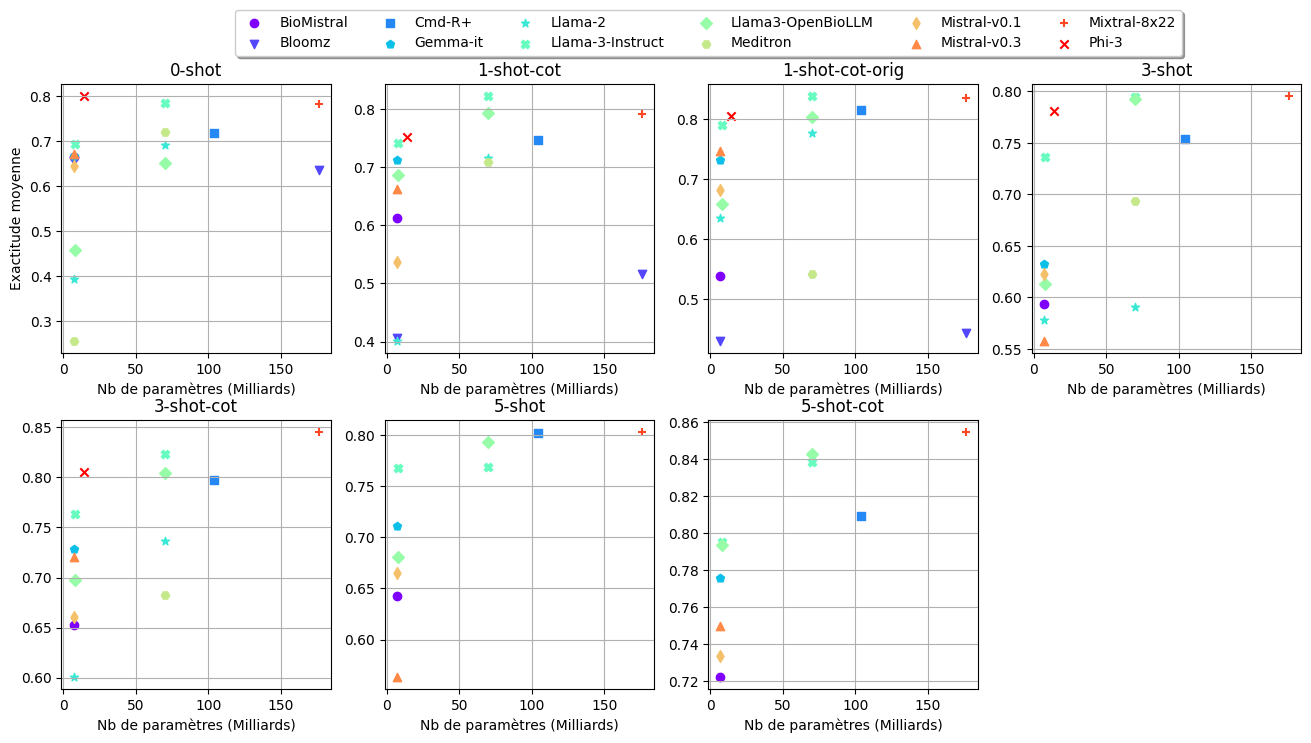

In [6]:
fig = plt.figure(figsize=(16,8))
gs = GridSpec(2, 4, figure=fig)
group = pivoted_df["shortname"]
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(group))))
markers = "ovsp*XDHd^+x."

for i,prompting_method in enumerate(sorted(df["prompting"].unique())):
    x = pivoted_df["size"].to_numpy()
    y = pivoted_df[prompting_method].to_numpy()
    
    if i <= 3 :
        axes = fig.add_subplot(gs[0, i])
    else :
        axes = fig.add_subplot(gs[1, i-4])
    for g, color, marker in zip(np.unique(group), colors, markers):
        subset = []
        # remove element in subset where y=nan
        for s in np.where(group == g)[0] :
            if y[s] != np.nan:
                subset.append(s)
        if not subset: continue
        axes.scatter(x[subset], y[subset], label=g, color=color, marker=marker)
    axes.set_xlabel("Nb de paramètres (Milliards)")
    if i == 0 :
        axes.set_ylabel("Exactitude moyenne")
    elif i == 2 :
        axes.legend(loc="upper center",bbox_to_anchor=(0,1.3), ncol=6, fancybox=True, shadow=True)
    axes.set_title(prompting_method)
    axes.set_box_aspect(1)
    axes.grid()
fig.savefig('figures/model_comparison.png')

## performances des modèles avec filtrage de phrases

on l'effectue uniquement sur le modèle Llama-2-70b-chat-hf pour ses différentes méthodes de prompting

In [18]:
# calcul des performances des modèles sans filtrage avec le sous ensemble de critères
corpus = "covid"
no_filter_results = []
for result_dir in glob.glob("../inference/out/*_Llama-2-70b-chat-hf/"):
    if 'filt-sent' in result_dir : continue
    # parse result_dir name
    corpus, method, model = result_dir.split('/')[-2].split('_')
    # filt-sent criteria subset
    criteria_subset = pd.read_csv(f"../inference/out/{corpus}_0-shot_filt-sent_Llama-2-70b-chat-hf/predictions.csv",index_col='fid').columns
    # load data
    exp_config = json.load(open(os.path.join(result_dir,"exp_config.json")))
    pred_df = pd.read_csv(os.path.join(result_dir,"predictions.csv"), index_col="fid").sort_index()[criteria_subset]
    true_df = pd.read_csv(f"../consort-qa/{exp_config['dataset']}/labels.csv", index_col="fid").sort_index()[criteria_subset]
    assert true_df.index.equals(pred_df.index), "Predictions and labels do not have the same fids"
    no_filter_results.append({
        "method":method,
        "dataset":corpus,
        "accuracy":classification_report(pred_df.to_numpy().flatten(), true_df.to_numpy().flatten())["accuracy"]
    })
no_filt_df = pd.DataFrame(no_filter_results)
covid  = no_filt_df[no_filt_df["dataset"]=="covid"].drop(columns="dataset")
dep = no_filt_df[no_filt_df["dataset"]=="depression-rct"].drop(columns="dataset")
no_filt_df = pd.merge(covid,dep,how='outer', on="method", suffixes=("_covid","_depression"))
no_filt_df["accuracy_mean"] = no_filt_df[["accuracy_covid","accuracy_depression"]].mean(axis=1)
no_filt_df = no_filt_df.drop(columns=["accuracy_covid","accuracy_depression"])
no_filt_df["filtering"] = ["no filtering"]*len(no_filt_df)
no_filt_df

,method,accuracy_mean,filtering
0,0-shot,0.704503,no filtering
1,1-shot,0.747811,no filtering
2,cot,0.778577,no filtering


In [19]:
# Tableau des résultats avec filtrage des phrases
filt_df = df[df["filter_sentences"] == True].drop(columns=["filter_sentences"])
filt_df = filt_df[filt_df["add_system_prompt"] == False ].drop(columns=["add_system_prompt"])
filt_df = filt_df[filt_df["model_type"] == "llama-2" ].drop(columns=["model_type"])
filt_df = filt_df[filt_df["model_size"] == 70 ].drop(columns=["model_size"])
filt_df = filt_df[filt_df["is_chat_model"] == True ].drop(columns=["is_chat_model"])
covid  = filt_df[filt_df["dataset"]=="covid"].drop(columns="dataset")
dep = filt_df[filt_df["dataset"]=="depression-rct"].drop(columns="dataset")
filt_df = pd.merge(covid,dep,how='outer', on="method", suffixes=("_covid","_depression"))
filt_df["accuracy_mean"] = filt_df[["accuracy_covid","accuracy_depression"]].mean(axis=1)
filt_df = filt_df.drop(columns=["accuracy_covid","accuracy_depression"])
filt_df["filtering"] = ["sentence filtering"]*len(no_filt_df)
filt_df

,method,accuracy_mean,filtering
0,0-shot,0.692424,sentence filtering
1,cot,0.775000,sentence filtering
2,1-shot,0.754377,sentence filtering


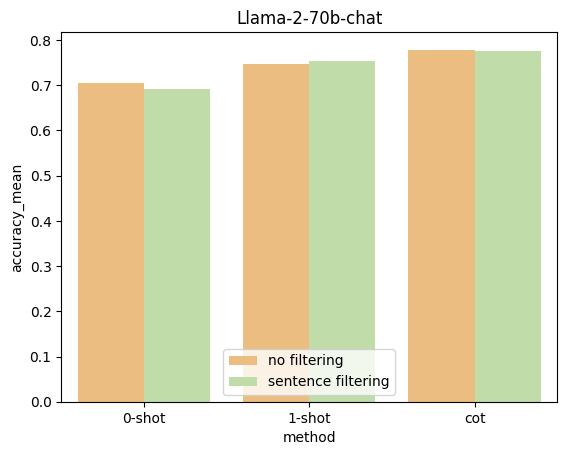

In [24]:
comp_df = pd.concat([no_filt_df,filt_df])
#comp_df = comp_df.rename(columns={"method":"stratégie de prompting","accuracy_mean":"exactitude moyenne","filtering":"filtrage"})
sb.barplot(comp_df, x="method", y="accuracy_mean", hue="filtering", palette="Spectral")
plt.legend(loc="lower center")
plt.title("Llama-2-70b-chat")
plt.savefig("figures/sentence_filtering_results.png")

## performances détaillées par critère CONSORT

In [53]:
best_model = df["model"][0]

In [66]:
per_crit_results = []
for p in glob.glob(f"../inference_vllm/out/*cot*_{best_model}/metrics.json"):
    item_accuracies = { item:metrics["accuracy"] for item, metrics in json.load(open(p))["per_criteria"].items() }
    per_crit_results.append({
        "prompting_method": p.split('/')[-2].split('_')[0],
        **item_accuracies
    })
all_crit_df = pd.DataFrame(per_crit_results)

# get test set pre criteria main class
majority_class = { c:Counter() for c in all_crit_df.columns[1:].tolist()}
with jsonlines.open('../data/test.jsonl') as element_list:
    for obj in element_list:
        for cid, label in obj["answers"].items() :
            majority_class[cid].update([label])
majority_class = {cid:counter.most_common(1)[0][1]/sum(counter.values()) for cid,counter in majority_class.items()}
majority_class["prompting_method"]="majority_class"
all_crit_df.loc[len(df)] = majority_class
all_crit_df = all_crit_df.sort_values(by="prompting_method")
all_crit_df

,prompting_method,D01,D02,D03a,D03b,D04a,D04b,D05,D06a,D06b,...,C11,C11a,C12a,C12b,C12c,C13,C14,C14a,C15,C16
1,1-shot-cot,0.775641,0.576923,0.596154,0.846154,0.621795,0.589744,0.788462,0.935897,0.589744,...,0.942857,0.685714,0.514286,0.742857,0.857143,0.971429,1.000000,0.657143,0.971429,0.942857
2,1-shot-cot-orig,0.961538,0.455128,0.705128,0.814103,0.750000,0.615385,0.884615,0.916667,0.551282,...,0.771429,0.400000,0.600000,0.885714,0.857143,0.971429,0.885714,0.342857,1.000000,0.971429
3,3-shot-cot,0.980769,0.737179,0.551282,0.839744,0.679487,0.660256,0.762821,0.955128,0.621795,...,0.942857,0.485714,0.714286,0.828571,0.885714,0.971429,1.000000,0.742857,1.000000,0.971429
0,5-shot-cot,0.967949,0.807692,0.673077,0.743590,0.730769,0.743590,0.730769,0.955128,0.724359,...,0.914286,0.571429,0.600000,0.800000,0.800000,0.971429,0.971429,0.771429,1.000000,0.971429
97,majority_class,0.589744,0.692308,0.807692,0.660256,0.532051,0.525641,0.910256,0.852564,0.519231,...,0.800000,0.914286,0.514286,0.571429,0.600000,0.514286,1.000000,0.542857,0.685714,0.800000


In [67]:
##### from plotly.subplots import make_subplots
import plotly.graph_objects as go

for dataset_prefix in ["C","D"]:
    per_crit_df = all_crit_df[[c for c in all_crit_df.columns if c.startswith(dataset_prefix) or c == "prompting_method"]]
    fig = go.Figure()
    categories = list(per_crit_df.columns[1:])
    for index, row in per_crit_df.iterrows():
        fig.add_trace(
            go.Scatterpolar(
                r=row[categories],
                theta=categories,
                name=row['prompting_method']
            )
        )
    
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1],
          nticks=10,
          color="#b106a6"
        )),
      showlegend=True,
      legend=dict(
            x=-0.1,  # Adjust the x position
            y=0.9  # Adjust the y position
        ),
    )

    fig.write_image(f"figures/{dataset_prefix}_radarchart.png")

## corrélation kappa et performance par critère

In [11]:
kappa_df = pd.read_csv("../data/csv/kappas.csv").dropna(subset=["kappa"])
kappa_df = kappa_df[kappa_df.kappa != 0]
kappa_df.head()

,id,kappa,question,corr_id
0,D01,0.96,Is the study identified as randomized in the t...,C01
1,D02,0.38,Is there a structured summary of the trial des...,C02
2,D03a,0.77,Are the eligibility criteria for participants ...,C03a
3,D03b,0.81,Are the settings or locations where the data w...,C03b
4,D04a,0.80,Do the authors report essential features of th...,C04


In [34]:
correlations = []
model_subset = ["Mixtral-8x22B-Instruct-v0.1","Meta-Llama-3-70B-Instruct","Llama3-OpenBioLLM-70B"]
for row in df.to_dict("records") : # TOP 5 MODEL+PROMPTING 
    model = row["model"]
    if model not in model_subset:continue
    strategy = row["prompting"]
    metrics_path = f"../inference_vllm/out/{strategy}_{model}/metrics.json"
    if os.path.exists(metrics_path):
        item_accuracies = { item:metrics["accuracy"] for item, metrics in json.load(open(metrics_path))["per_criteria"].items() }
        kappa_df[model] = kappa_df["id"].apply(lambda x : item_accuracies[x])
        pearson_corr = stats.pearsonr(kappa_df["kappa"],kappa_df[model]).statistic
        correlations.append({
            "model":model,
            "strategy":strategy,
            "pearsonr":pearson_corr,
        })
corr_df = pd.DataFrame(correlations).pivot(index='model', columns='strategy', values='pearsonr')
corr_df

strategy,0-shot,1-shot-cot,1-shot-cot-orig,3-shot,3-shot-cot,5-shot,5-shot-cot
model,,,,,,,
Llama3-OpenBioLLM-70B,0.222166,0.313235,0.362135,-0.041842,0.028296,0.067570,-0.116371
Meta-Llama-3-70B-Instruct,0.041173,0.374482,0.454750,0.518907,0.407920,0.510998,0.191904
Mixtral-8x22B-Instruct-v0.1,0.418343,0.362648,0.532824,0.360779,0.122356,0.262941,0.026228


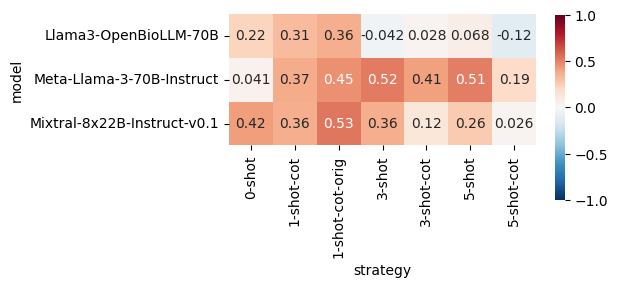

In [52]:
ax = sb.heatmap(corr_df,annot=True, cmap='RdBu_r', vmin=-1, vmax=1,square=True, cbar_kws={"anchor":(0.0,0.35),"shrink":0.5})
ax.figure.subplots_adjust(left = 0.3)
plt.savefig("figures/pearsonr_top-3.png")

## Errors recap graph

In [24]:
data = json.load(open("fn-fp_annotations_corrected.json"))
counts = {
    "question_understanding":[0,0,0],
    "context_relevance":[0,0,0],
    "answer_relevance":[0,0,0]
}
for pred_type,fnames_dict in data.items():
    for fname,label_dict in fnames_dict.items():
        for qid, val in label_dict.items():
            counts[qid][int(val)] += 1

In [25]:
counts

{'question_understanding': [17, 54, 29],
 'context_relevance': [10, 11, 79],
 'answer_relevance': [1, 6, 93]}

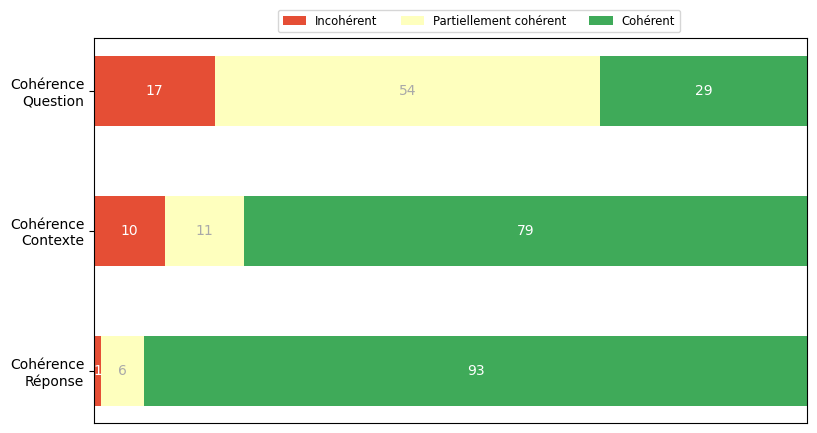

In [34]:
category_names = ['Incohérent', 'Partiellement cohérent','Cohérent']
results = {
    'Cohérence\nQuestion': [17, 54, 29],
    'Cohérence\nContexte': [10, 11, 79],
    'Cohérence\nRéponse': [1, 6, 93],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0.25, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.savefig("figures/error_analysis.png")

# Error analysis

## qualitative analysis annotation

In [2]:
# Load true data
id_true = {f"{el['id']}_{cid}.txt":ans for el in jsonlines.open('../data/test.jsonl') for cid,ans in el["answers"].items()}
# Load pred data
pred_dir = f'../inference_vllm/out/5-shot-cot_Mixtral-8x22B-Instruct-v0.1/'
id_pred = json.load(open(os.path.join(pred_dir,"predictions.json")))
txt_paths = glob.glob(os.path.join(pred_dir,"txt/*.txt"))

In [3]:
pred_types = {"tp":[],"tn":[],"fp":[],"fn":[]}
for fname, pred in id_pred.items():
    true = id_true[fname.replace("@","/")]
    ans_type = "tp"
    if pred == "No" and true == "No":
        pred_types["tn"].append(fname)
    elif pred == "No" and true == "Yes":
        pred_types["fn"].append(fname)
    elif pred == "Yes" and true == "No":
        pred_types["fp"].append(fname)
    else :
        pred_types["tp"].append(fname)

In [4]:
len(pred_types["tn"])

2462

In [5]:
sampling_length = 50
output_file = "tn-tp_annotations.json"
# set random seed
random.seed(42)
if os.path.exists(output_file):
    annotations = json.load(open(output_file))
else :
    annotations = {"tp":{},"tn":{}}
for pred_type, filenames in pred_types.items():
    if pred_type in ["tp","tn"] :
        for f in random.sample(filenames,sampling_length) :
            if f in annotations[pred_type] and annotations[pred_type][f]:
                print("already annotated")
                continue
            full_text_lines = open(os.path.join(pred_dir,"txt",f)).readlines()
            test_text = [sublist for sublist in ''.join(full_text_lines).split('\n\n') if sublist][-1]
            print(test_text)
            print("-----------------")
            print("the answer is a ", pred_type)
            annot = input("does the explanation corresponds to the answer ?")
            annotations[pred_type][f] = annot
            json.dump(annotations,open(output_file,"w"))
            print('________________________________________')

already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already annotated
already an

In [15]:
sampling_length = 50
output_file = "fn-fp_annotations.json"
questions = [
    ("Understand question (0:no / 1:partially / 2:completely)","question_understanding"),
    ("Relevant citation of context (0:no / 1:partial / 2:complete)","context_relevance"),
    ("Relevant answer (0:no means explanation correct but wrong answer / 1:unclear/  2:yes, answer relevant even if wrong)","answer_relevance")
]
# set random seed
random.seed(42)
if os.path.exists(output_file):
    annotations = json.load(open(output_file))
else :
    annotations = {"fp":{},"fn":{}}
for pred_type, filenames in pred_types.items():
    if pred_type in ["fp","fn"] :
        for f in random.sample(filenames,sampling_length) :
            full_text_lines = open(os.path.join(pred_dir,"txt",f)).readlines()
            test_text = [sublist for sublist in ''.join(full_text_lines).split('\n\n') if sublist][-1]

            if f in annotations[pred_type] and annotations[pred_type][f]:
                for question, qid in questions:
                    if annotations[pred_type][f][qid] not in ["0","1","2"]:
                        print(test_text)
                        print("-----------------")
                        print("the answer is a ", pred_type)
                        annotations[pred_type][f][qid] = input(annotations[pred_type][f][qid] + question)
                        print(annotations[pred_type][f][qid])
                        json.dump(annotations,open("fn-fp_annotations_corrected.json","w"))
                continue
            
            print(test_text)
            print("-----------------")
            print("the answer is a ", pred_type)
            dimension_annots = {}
            for question, qid in questions:
                dimension_annots[qid] = input(question)
            annotations[pred_type][f] = dimension_annots
            json.dump(annotations,open(output_file,"w"))
            print('________________________________________')

Context : '''Title : A Parenting and Life Skills Intervention for Teen Mothers: A Randomized Controlled Trial.
Unlabelled : : media-1vid110.1542/5985300176001PEDS-VA_2018-2303 Video Abstract BACKGROUND: Teen mothers often present with depression, social complexity, and inadequate parenting skills. Many have rapid repeat pregnancy, which increases risk for poor outcomes. We conducted a randomized controlled trial of a parenting and life skills intervention for teen mothers aimed at impacting parenting and reproductive outcomes.
Methods : Teen mothers were recruited from a teen-tot clinic with integrated medical care and social services. Participants were randomly assigned 1:1 to receive (1) teen-tot services plus 5 interactive parenting and life skills modules adapted from the Nurturing and Ansell-Casey Life Skills curricula, delivered by a nurse and social worker over the infant's first 15 months or (2) teen-tot services alone. A computerized questionnaire was self-administered at inta

-1Relevant citation of context (0:no / 1:partial / 2:complete) 2


2
Context : '''Title : Healthy learning mind – Effectiveness of a mindfulness program on mental health compared to a relaxation program and teaching as usual in schools: A cluster-randomised controlled trial
Background : Mindfulness-Based Interventions (MBIs) have shown promising effects on mental health among children and adolescents, but high-quality studies examining the topic are lacking. The present study assessed the effects of MBI on mental health in school-setting in an extensive randomised controlled trial.
Methods : Finnish school children and adolescents (N = 3519), aged 12–15 years (6th to 8th graders), from 56 schools were randomized into a 9 week MBI group, and control groups with a relaxation program or teaching as usual. The primary outcomes were resilience, socio-emotional functioning, and depressive symptoms at baseline, at completion of the programs at 9 weeks (T9), and at follow-up at 26 weeks (T26).
Results : Overall, mindfulness did not show more beneficial effect

 0Understand question (0:no / 1:partially / 2:completely) 1


1


## Sampling errors by type

In [1]:
pred_dir = f'../inference_vllm/out/5-shot-cot_Mixtral-8x22B-Instruct-v0.1/'